Notebook from https://doi.org/10.1038/s41467-024-51844-2

# Imports and env. variables

In [1]:
import os

In [2]:
# Set environment variables to run Deepspeed from a notebook
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "9993"  # modify if RuntimeError: Address already in use
os.environ["RANK"] = "0"
os.environ["LOCAL_RANK"] = "0"
os.environ["WORLD_SIZE"] = "1"

In [3]:
# Use correct cuda version in conda environment
os.environ["CUDA_HOME"] = os.environ["CONDA_PREFIX"]

In [4]:
import pickle, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Dict, List, Optional, Tuple, Union
from collections import OrderedDict
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, TrainingArguments, Trainer, EarlyStoppingCallback, set_seed
from transformers.models.esm.modeling_esm import EsmPreTrainedModel, EsmModel
from transformers.modeling_outputs import TokenClassifierOutput
from datasets import Dataset
from evaluate import load

# for custom DataCollator
from transformers.data.data_collator import DataCollatorMixin
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from transformers.utils import PaddingStrategy
from dataclasses import dataclass

from peft import inject_adapter_in_model, LoraConfig

## Model checkpoint

In [5]:
checkpoint = "facebook/esm2_t33_650M_UR50D" # "facebook/esm2_t36_3B_UR50D"

# Input data

In [6]:
with open("../training_data/5.Embeddings/seq_embeddings.pkl", "rb") as f:
    seqs = {pdb: {ent: {"seq": entd["seq"]} for ent, entd in pdbd.items()} for pdb, pdbd in pickle.load(f).items()}

seqs

{'5kwj': {'1': {'seq': 'MFSRPGLPVEYLQVPSASMGRDIKVQFQGGGPHAVYLLDGLRAQDDYNGWDINTPAFEEYYQSGLSVIMPVGGQSSFYTDWYQPSQSNGQNYTYKWETFLTREMPAWLQANKGVSPTGNAAVGLSMSGGSALILAAYYPQQFPYAASLSGFLNPSEGWWPTLIGLAMNDSGGYNANSMWGPSSDPAWKRNDPMVQIPRLVANNTRIWVYCGNGTPSDLGGDNIPAKFLEGLTLRTNQTFRDTYAADGGRNGVFNFPPNGTHSWPYWNEQLVAMKADIQHVLNGATPPAAPAAPAALEHHHHHH'}},
 '6t4k': {'1': {'seq': 'GSSHHHHHHSSGLVPRGSHMASLTEIEHLVQSVCKSYRETCQLRLEDLLRQRSNIFSREEVTGYQRKSMWEMWERCAHHLTEAIQYVVEFAKRLSGFMELCQNDQIVLLKAGAMEVVLVRMCRAYNADNRTVFFEGKYGGMELFRALGCSELISSIFDFSHSLSALHFSEDEIALYTALVLINAHRPGLQEKRKVEQLQYNLELAFHHHLHKTHRQSILAKLPPKGKLRSLCSQHVERLQIFQHLHPIVVQAAFPPLYKELFS'}},
 '5mo6': {'1': {'seq': 'GSMDIEFDDDADDDGSGSGSGSGSSGPVPSRARVYTDVNTHRPSEYWDYESHVVEWGNQDDYQLVRKLGRGKYSEVFEAINITNNEKVVVKILKPVKKKKIKREIKILENLRGGPNIITLADIVKDPVSRTPALVFEHVNNTDFKQLYQTLTDYDIRFYMYEILKALDYCHSMGIMHRDVKPHNVMIDHEHRKLRLIDWGLAEFYHPGQEYNVRVASRYFKGPELLVDYQMYDYSLDMWSLGCMLASMIFRKEPFFHGHDNYDQLVRIAKVLGTEDLYDYIDKYNIELDPRFNDILGRHSRKRWERFVHSENQHLVSPEALDFLDKLLRYDHQSRLTAREAMEHPYFYTVVK

In [7]:
def get_seqs(protein_dict, residues_df):
    return pd.DataFrame([
    {
        "pdb": pdb,
        "label_entity_id": entity_id,
        "sequence": data["seq"],
        "label": [
            1 if ( # check if in any instance of the label_seq_id (in any of the label_asym_id) there is any label 1, else 0
                residues.loc[ residues[("Residues", "label_seq_id")] == str(i) ][("Label", "label")].max()
            ) == 1 
            else 0
            # For each expected label_seq_id
            for i in range(1, len(data["seq"]) + 1)
        ],
        "mask": [1] * len(data["seq"]),
    }
        
    # For each PDB
    for pdb, entities in protein_dict.items()
        # For each entity-seq
        for entity_id, data in entities.items()
            # Get the labelled residues of the entity-seq
            for residues in [
                residues_df.loc[( residues_df[("Residues", "pdb")] == pdb ) & ( residues_df[("Residues", "label_entity_id")] == entity_id )]
            ]
])

## Train

In [8]:
with open("../training_data/6.Training_sets/residues_train.pkl", "rb") as f:
    train_feats = pickle.load(f)

train_feats

Residues                                                          \
         pdb label_entity_id label_asym_id label_seq_id auth_asym_id   
0       6ta3               2             B            1            A   
1       6ta3               2             B            2            A   
2       6ta3               2             B            3            A   
3       6ta3               2             B            4            A   
4       6ta3               2             B            5            A   
..       ...             ...           ...          ...          ...   
419     3d2p               1             A          452            A   
420     3d2p               1             A          453            A   
421     3d2p               1             A          454            A   
422     3d2p               1             A          455            A   
423     3d2p               1             A          456            A   

                                  Label     Amino acids                  ...  \
    auth_seq_id pdbx_PDB_ins_code label label_comp_id_A label_comp_id_C  ...   
0             1                 ?     0               0               0  ...   
1             2                 ?     0               0               0  ...   
2             3                 ?     0               0               0  ...   
3             4                 ?     0               0               1  ...   
4             5                 ?     0               0               0  ...   
..          ...               ...   ...             ...             ...  ...   
419         432                 ?     0               0               0  ...   
420         433                 ?     0               0               0  ...   
421         434                 ?     0               0               0  ...   
422         435                 ?     0               0               0  ...   
423         436                 ?     0               0               0  ...   

      HHBlits                                                              \
         M->M      M->I M->D      I->M      I->I D->M D->D    Neff Neff_I   
0    0.998615  0.001223  0.0  1.000000  0.000000  0.0  0.0   9.088  1.005   
1    1.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0   9.860  0.000   
2    0.997923  0.001963  0.0  0.656106  0.343885  0.0  0.0   9.988  1.007   
3    0.999307  0.000605  0.0  0.333325  0.666649  0.0  0.0  10.047  1.000   
4    1.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  10.026  0.000   
..        ...       ...  ...       ...       ...  ...  ...     ...    ...   
419  1.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  10.906  0.000   
420  1.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  10.787  0.000   
421  0.994470  0.005799  0.0  1.000000  0.000000  0.0  0.0  10.713  1.002   
422  1.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  10.639  0.000   
423  1.000000  0.000000  0.0  1.000000  0.000000  0.0  0.0  10.958  0.000   

            
    Neff_D  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
..     ...  
419    0.0  
420    0.0  
421    0.0  
422    0.0  
423    0.0  

[108406 rows x 174 columns]

In [9]:
train_seqs = get_seqs(
    {k: v for k, v in seqs.items() if k in train_feats[("Residues", "pdb")].unique()}, 
    train_feats[["Residues", "Label"]]
)

train_seqs

,pdb,label_entity_id,sequence,label,mask
0,5mo6,1,GSMDIEFDDDADDDGSGSGSGSGSSGPVPSRARVYTDVNTHRPSEY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1tjp,1,MERYENLFAQLNDRREGAFVPFVTLGDPGIEQSLKIIDTLIDAGAD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,4bqh,1,PLGSMSDRDVCIQRLTGANQDHILTALEHGSEAERASLTAQITNEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1og0,1,MSESPMFAANGMPKVNQGAEEDVRILGYDPLASPALLQVQIPATPT...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,5jv1,1,MGSSHHHHHHSSGRENLYFQGHMNGDQNSDVYAQEKQDFVQHFSQI...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...
241,4fha,1,MSYQDLKECKIITAFITPFHEDGSINFDAIPALIEHLLAHHTDGIL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
242,4zht,1,MEKNGNNRKLRVCVATCNRADYSKLAPIMFGIKTEPEFFELDVVVL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
243,8fe1,1,MFALGIYLWETIVFFSLAASQQAAARKAASPMPPSEFLDKLMGKVS...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
244,8fe1,2,MKALKVIFMLLIICLWMEGGFTKEKSAKKWSHPQFEKGGGSGGGSG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### Validation

In [10]:
valid_seqs = train_seqs.sample(frac=0.2, random_state=0)

print( len(valid_seqs) )
valid_seqs

49


,pdb,label_entity_id,sequence,label,mask
89,6cwy,2,MGSSHHHHHHSSGLVPRGSHMALSRGLPRELAEAVAGGRVLVVGAG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
108,2p9g,1,MAKVSLEKDKIKFLLVEGVHQKALESLRAAGYTNIEFHKGALDDEQ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
74,6usa,1,MVAVEQSEASRLGPVFDSCRANNRAALIGYLPTGYPDVPASVAAMT...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
109,4b6e,1,MGSSHHHHHHSSGLVPRGSHMGSVVIVGRIILSGSGSITAYSQQTR...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
71,5x33,1,ELMDYKDDDDKEFSNTFIPLLAMILLSVSMVVGLPGNTFVVWSILK...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
126,4or2,1,GGTADLEDNWETLNDNLKVIEKADNAAQVKDALTKMRAAALDAQKA...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
104,6huj,3,MSSPNIWSTGSSVYSTPVFSQKMTVWILLLLSLYPGFTSQKSDDDY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
138,7dtu,1,MKTIIALSYIFCLVFADYKDDDDENLYFQGYGPDQRAQKKGDIILG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
154,6ku3,1,MVVLAGPPAVDHIPLLRSPDPGDVFSGVPVVDLGSPGAARAVVDAC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
199,5f74,1,MTMDKSELVQKAKLAEQAERYDDMAAAMKAVTEQGHELSNEERNLL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [11]:
train_seqs = train_seqs[lambda x: ~x.index.isin(valid_seqs.index)]

train_seqs

,pdb,label_entity_id,sequence,label,mask
0,5mo6,1,GSMDIEFDDDADDDGSGSGSGSGSSGPVPSRARVYTDVNTHRPSEY...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1tjp,1,MERYENLFAQLNDRREGAFVPFVTLGDPGIEQSLKIIDTLIDAGAD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,4bqh,1,PLGSMSDRDVCIQRLTGANQDHILTALEHGSEAERASLTAQITNEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1og0,1,MSESPMFAANGMPKVNQGAEEDVRILGYDPLASPALLQVQIPATPT...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,5jv1,1,MGSSHHHHHHSSGRENLYFQGHMNGDQNSDVYAQEKQDFVQHFSQI...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...
241,4fha,1,MSYQDLKECKIITAFITPFHEDGSINFDAIPALIEHLLAHHTDGIL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
242,4zht,1,MEKNGNNRKLRVCVATCNRADYSKLAPIMFGIKTEPEFFELDVVVL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
243,8fe1,1,MFALGIYLWETIVFFSLAASQQAAARKAASPMPPSEFLDKLMGKVS...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
244,8fe1,2,MKALKVIFMLLIICLWMEGGFTKEKSAKKWSHPQFEKGGGSGGGSG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [12]:
train_seqs["label"].apply(len).mean()

416.28934010152284

## Test

In [13]:
with open("../training_data/6.Training_sets/residues_test.pkl", "rb") as f:
    test_feats = pickle.load(f)

test_feats

Residues                                                          \
         pdb label_entity_id label_asym_id label_seq_id auth_asym_id   
0       5kwj               1             B            1            B   
1       5kwj               1             B            2            B   
2       5kwj               1             B            3            B   
3       5kwj               1             B            4            B   
4       5kwj               1             B            5            B   
..       ...             ...           ...          ...          ...   
254     4op0               1             A          263            A   
255     4op0               1             A          264            A   
256     4op0               1             A          265            A   
257     4op0               1             A          266            A   
258     4op0               1             A          267            A   

                                  Label     Amino acids                  ...  \
    auth_seq_id pdbx_PDB_ins_code label label_comp_id_A label_comp_id_C  ...   
0             0                 ?     0               0               0  ...   
1             1                 ?     0               0               0  ...   
2             2                 ?     0               0               0  ...   
3             3                 ?     0               0               0  ...   
4             4                 ?     0               0               0  ...   
..          ...               ...   ...             ...             ...  ...   
254         261                 ?     0               0               0  ...   
255         262                 ?     0               0               0  ...   
256         263                 ?     0               0               0  ...   
257         264                 ?     0               0               0  ...   
258         265                 ?     0               0               0  ...   

      HHBlits                                                              \
         M->M      M->I      M->D      I->M      I->I      D->M      D->D   
0    0.985549  0.000000  0.014548  0.000000  0.000000  0.000000  0.000000   
1    1.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
2    0.988286  0.011817  0.000000  1.000000  0.000000  0.000000  0.000000   
3    0.995850  0.004370  0.000000  0.500000  0.500000  0.000000  0.000000   
4    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
254  0.993781  0.004597  0.001520  0.593368  0.406408  0.754190  0.246046   
255  0.988971  0.006289  0.004566  0.549427  0.450625  1.000000  0.000000   
256  0.980099  0.002661  0.017122  0.753667  0.246387  0.690637  0.309498   
257  1.000000  0.000000  0.000000  0.000000  0.000000  0.866337  0.133508   
258  1.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   

                           
       Neff Neff_I Neff_D  
0    10.217  0.000  0.000  
1    11.268  0.000  1.005  
2    11.773  1.031  0.000  
3    11.926  1.004  0.000  
4    12.055  0.000  0.000  
..      ...    ...    ...  
254   8.557  1.043  1.019  
255   8.474  1.063  1.013  
256   8.460  1.014  1.053  
257   8.301  0.000  1.189  
258   8.215  0.000  1.016  

[31725 rows x 174 columns]

In [14]:
test_seqs = get_seqs(
    {k: v for k, v in seqs.items() if k in test_feats[("Residues", "pdb")].unique()}, 
    test_feats[["Residues", "Label"]]
)

test_seqs

,pdb,label_entity_id,sequence,label,mask
0,5kwj,1,MFSRPGLPVEYLQVPSASMGRDIKVQFQGGGPHAVYLLDGLRAQDD...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,6t4k,1,GSSHHHHHHSSGLVPRGSHMASLTEIEHLVQSVCKSYRETCQLRLE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,3o0n,1,MKLSDLISRWIDVEPSKNAQIILRDRYFMKDLDGNYLETKWEDVAR...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,6nzf,1,MGSSHHHHHHSSGETVRFQGHMNLSQLSFHRVDQKEITQLSHLGQG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,5uyy,1,SNAMKIKKESLEMRQMRKKVVLIGTGLIGGSLALAIKKDHDVTITG...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...
58,6izw,1,MSFINYSSREINCKIVYYGPGLCGKTTNLQYIYNKTAAETKGKLIS...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
59,8gti,1,MEILNEEKKSKVHYHVAAIINYLGHCISLVALLVAFVLFLRARSIR...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
60,6czm,1,SNATHHQVLNGNTVSRQEIRLGLPSKGRMSSDTLDLLKDCQLSVKQ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
61,4tme,1,MKNDLIRPNVLSVKIISNVSPEMAKKLELEPHHKSLGLITADCDDV...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


# Models and Low Rank Adaptation

### Classification model definition and DataCollator

In [15]:
class EsmForTokenClassificationCustom(EsmPreTrainedModel):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.esm = EsmModel(config, add_pooling_layer=False)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, TokenClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Labels for computing the token classification loss. Indices should be in `[0, ..., config.num_labels - 1]`.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.esm(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        # changed to ignore special tokens at the seq start and end 
        # as well as invalid positions (labels -100)
        if labels is not None:
            loss_fct = CrossEntropyLoss()

            active_loss = attention_mask.view(-1) == 1
            active_logits = logits.view(-1, self.num_labels)

            active_labels = torch.where(
              active_loss, labels.view(-1), torch.tensor(-100).type_as(labels)
            )

            valid_logits=active_logits[active_labels!=-100]
            valid_labels=active_labels[active_labels!=-100]
            
            valid_labels=valid_labels.type(torch.LongTensor).to('cuda:0')
            
            loss = loss_fct(valid_logits, valid_labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

    
# based on transformers DataCollatorForTokenClassification
@dataclass
class DataCollatorForTokenClassificationESM(DataCollatorMixin):
    """
    Data collator that will dynamically pad the inputs received, as well as the labels.
    Args:
        tokenizer ([`PreTrainedTokenizer`] or [`PreTrainedTokenizerFast`]):
            The tokenizer used for encoding the data.
        padding (`bool`, `str` or [`~utils.PaddingStrategy`], *optional*, defaults to `True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            - `True` or `'longest'` (default): Pad to the longest sequence in the batch (or no padding if only a single
              sequence is provided).
            - `'max_length'`: Pad to a maximum length specified with the argument `max_length` or to the maximum
              acceptable input length for the model if that argument is not provided.
            - `False` or `'do_not_pad'`: No padding (i.e., can output a batch with sequences of different lengths).
        max_length (`int`, *optional*):
            Maximum length of the returned list and optionally padding length (see above).
        pad_to_multiple_of (`int`, *optional*):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
        label_pad_token_id (`int`, *optional*, defaults to -100):
            The id to use when padding the labels (-100 will be automatically ignore by PyTorch loss functions).
        return_tensors (`str`):
            The type of Tensor to return. Allowable values are "np", "pt" and "tf".
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    label_pad_token_id: int = -100
    return_tensors: str = "pt"

    def torch_call(self, features):
        import torch

        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature[label_name] for feature in features] if label_name in features[0].keys() else None

        no_labels_features = [{k: v for k, v in feature.items() if k != label_name} for feature in features]

        batch = self.tokenizer.pad(
            no_labels_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        if labels is None:
            return batch

        sequence_length = batch["input_ids"].shape[1]
        padding_side = self.tokenizer.padding_side

        def to_list(tensor_or_iterable):
            if isinstance(tensor_or_iterable, torch.Tensor):
                return tensor_or_iterable.tolist()
            return list(tensor_or_iterable)

        if padding_side == "right":
            batch[label_name] = [
                # to_list(label) + [self.label_pad_token_id] * (sequence_length - len(label)) for label in labels
                # changed to pad the special tokens at the beginning and end of the sequence
                [self.label_pad_token_id] + to_list(label) + [self.label_pad_token_id] * (sequence_length - len(label)-1) for label in labels
            ]
        else:
            batch[label_name] = [
                [self.label_pad_token_id] * (sequence_length - len(label)) + to_list(label) for label in labels
            ]

        batch[label_name] = torch.tensor(batch[label_name], dtype=torch.float)
        return batch

def _torch_collate_batch(examples, tokenizer, pad_to_multiple_of: Optional[int] = None):
    """Collate `examples` into a batch, using the information in `tokenizer` for padding if necessary."""
    import torch

    # Tensorize if necessary.
    if isinstance(examples[0], (list, tuple, np.ndarray)):
        examples = [torch.tensor(e, dtype=torch.long) for e in examples]

    length_of_first = examples[0].size(0)

    # Check if padding is necessary.

    are_tensors_same_length = all(x.size(0) == length_of_first for x in examples)
    if are_tensors_same_length and (pad_to_multiple_of is None or length_of_first % pad_to_multiple_of == 0):
        return torch.stack(examples, dim=0)

    # If yes, check if we have a `pad_token`.
    if tokenizer._pad_token is None:
        raise ValueError(
            "You are attempting to pad samples but the tokenizer you are using"
            f" ({tokenizer.__class__.__name__}) does not have a pad token."
        )

    # Creating the full tensor and filling it with our data.
    max_length = max(x.size(0) for x in examples)
    if pad_to_multiple_of is not None and (max_length % pad_to_multiple_of != 0):
        max_length = ((max_length // pad_to_multiple_of) + 1) * pad_to_multiple_of
    result = examples[0].new_full([len(examples), max_length], tokenizer.pad_token_id)
    for i, example in enumerate(examples):
        if tokenizer.padding_side == "right":
            result[i, : example.shape[0]] = example
        else:
            result[i, -example.shape[0] :] = example
    return result

def tolist(x):
    if isinstance(x, list):
        return x
    elif hasattr(x, "numpy"):  # Checks for TF tensors without needing the import
        x = x.numpy()
    return x.tolist()

### Load ESM2 Model

In [16]:
#load ESM2 models
def load_esm_model_classification(checkpoint, num_labels, half_precision, full=False, deepspeed=True):
    
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    
    if half_precision and deepspeed:
        model = EsmForTokenClassificationCustom.from_pretrained(checkpoint, num_labels = num_labels, torch_dtype = torch.float16)
    else:
        model = EsmForTokenClassificationCustom.from_pretrained(checkpoint, num_labels = num_labels)
        
    if full == True:
        return model, tokenizer 
        
    peft_config = LoraConfig(
        r=4, lora_alpha=1, bias="all", target_modules=["query","key","value","dense"]
    )
    
    model = inject_adapter_in_model(peft_config, model)
    
    # Unfreeze the prediction head
    for (param_name, param) in model.classifier.named_parameters():
        param.requires_grad = True  
    
    return model, tokenizer

# Training Definition 

## Deepspeed config

In [17]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

## Training functions

In [20]:
# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

# Dataset creation
def create_dataset(tokenizer,seqs,labels,checkpoint):
    
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    
    if ("esm" in checkpoint) or ("ProstT5" in checkpoint):
        # we need to cut of labels after 1022 positions for the data collator to add the correct padding (1022 + 2 special tokens)
        labels = [l[:1022] for l in labels]       
    else:
        # we need to cut of labels after 1023 positions for the data collator to add the correct padding (1023 + 1 special tokens)
        labels = [l[:1023] for l in labels] 
        
    dataset = dataset.add_column("labels", labels)
     
    return dataset
    
# Main training fuction
def train_per_residue(
        checkpoint,       #model checkpoint
    
        train_df,         #training data
        valid_df,         #validation data      
        num_labels = 3,   #number of classes
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch = 4,        #for training
        accum = 2,        #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs = 10,      #training epochs
        lr = 3e-4,        #recommended learning rate
        seed = 42,        #random seed
        deepspeed = True,#if gpu is large enough disable deepspeed for training speedup
        mixed = True,     #enable mixed precision training
        full = True,     #enable training of the full model (instead of LoRA)
        gpu = 1 ):        #gpu selection (1 for first gpu)
    
    print("Model used:", checkpoint, "\n")
    
    # Correct incompatible training settings    
    if "ankh" in checkpoint and mixed:
        print("Ankh models do not support mixed precision training!")
        print("switched to FULL PRECISION TRAINING instead")
        mixed = False

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model_classification(checkpoint, num_labels, mixed, full, deepspeed)
    else:
        model, tokenizer = load_T5_model_classification(checkpoint, num_labels, mixed, full, deepspeed)

    # Preprocess inputs
    # Replace uncommon AAs with "X"
    train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z","J"]),"X",regex=True)
    
    # Add spaces between each amino acid for ProtT5 and ProstT5 to correctly use them
    if "Rostlab" in checkpoint:
        train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
        valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
        
    # Add <AA2fold> for ProstT5 to inform the model of the input type (amino acid sequence here)
    if "ProstT5" in checkpoint:    
        train_df['sequence']=train_df.apply(lambda row : "<AA2fold> " + row["sequence"], axis = 1)  
        valid_df['sequence']=valid_df.apply(lambda row : "<AA2fold> " + row["sequence"], axis = 1)

    # Create Datasets
    train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']),checkpoint)
    valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']),checkpoint)

    # Huggingface Trainer arguments
    args = TrainingArguments(
        "./residues_fine_tuning/",
        overwrite_output_dir = True,
        # eval_strategy = "steps", #we set this to "steps" because we train only for a single epoch here
        # eval_steps = 100,              #but still want to get intermediate evaluation results
        logging_strategy = "epoch",
        # save_strategy = "no",
        learning_rate=lr,
        per_device_train_batch_size=batch,
        #per_device_eval_batch_size=val_batch,
        per_device_eval_batch_size=batch,
        gradient_accumulation_steps=accum,
        num_train_epochs=epochs,
        seed = seed,
        deepspeed= ds_config if deepspeed else None,
        fp16 = mixed,

        load_best_model_at_end=True,
        metric_for_best_model = "eval_mcc",
        eval_strategy = "epoch",
        save_strategy = "best",
        save_total_limit=1
        # eval_strategy = "no",
    ) 

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        # metric = load("accuracy")
        metric = load("Yeshwant123/mcc")
        predictions, labels = eval_pred
        
        labels = labels.reshape((-1,))
        
        predictions = np.argmax(predictions, axis=2)
        predictions = predictions.reshape((-1,))
        
        predictions = predictions[labels!=-100]
        labels = labels[labels!=-100]
        
        return metric.compute(predictions=predictions, references=labels)

    # For token classification we need a data collator here to pad correctly
    # For esm2 and Prost pad at the beginning and at the end
    if ("esm" in checkpoint) or ("ProstT5" in checkpoint):
        data_collator = DataCollatorForTokenClassificationESM(tokenizer) 
    # For Ankh and ProtT5 pad only at the end
    else:
        data_collator = DataCollatorForTokenClassification(tokenizer)        

    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_set,
        eval_dataset=valid_set,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
    )    
    
    # Train model
    trainer.train()

    return tokenizer, model, trainer.state.log_history

# Run Training

## Training

In [21]:
tokenizer, model, history = train_per_residue(
        checkpoint,       #model checkpoint
    
        pd.DataFrame(train_seqs[["sequence", "label", "mask"]]),         #training data
        pd.DataFrame(valid_seqs[["sequence", "label", "mask"]]),         #validation data      
        num_labels = 2,   #number of classes
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch = 4,        #for training
        accum = 2,        #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs = 100,      #training epochs
        lr = 3e-4,        #recommended learning rate
        seed = 0,        #random seed
        deepspeed = True, #if gpu is large enough disable deepspeed for training speedup
        mixed = True,     #enable mixed precision training
        full = True,     #enable training of the full model (instead of LoRA)
        gpu = 1           #gpu selection (1 for first gpu)
)        

Model used: facebook/esm2_t33_650M_UR50D 



Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[2025-03-06 23:37:09,038] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
[2025-03-06 23:37:09,504] [INFO] [comm.py:652:init_distributed] cdb=None
[2025-03-06 23:37:09,504] [INFO] [comm.py:683:init_distributed] Initializing TorchBackend in DeepSpeed with backend nccl


/home/fnerin/miniconda3/envs/pybiomed/bin/../lib/gcc/x86_64-conda-linux-gnu/13.3.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -lcufile: No such file or directory
collect2: error: ld returned 1 exit status
/tmp/ipykernel_3706192/1975533747.py:137: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[2025-03-06 23:37:11,502] [WARNING] [cpu_adam.py:84:__init__] FP16 params for CPUAdam may not work on AMD CPUs
Installed CUDA version 11.7 does not match the version torch was compiled with 11.8 but since the APIs are compatible, accepting this combination


Using /home/fnerin/.cache/torch_extensions/py311_cu118 as PyTorch extensions root...
Emitting ninja build file /home/fnerin/.cache/torch_extensions/py311_cu118/cpu_adam/build.ninja...
Building extension module cpu_adam...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.
Time to load cpu_adam op: 2.140146255493164 seconds


Loading extension module cpu_adam...


Epoch,Training Loss,Validation Loss,Mcc
1,0.310400,0.206665,0.000000
2,0.184500,0.202759,0.140960
3,0.141100,0.223633,0.216156
4,0.099400,0.242554,0.183564
5,0.067500,0.254150,0.208172
6,0.043700,0.281982,0.226063
7,0.024500,0.274902,0.226386
8,0.014300,0.356689,0.208921
9,0.009400,0.325684,0.212347
10,0.006700,0.293701,0.216033


/home/fnerin/miniconda3/envs/pybiomed/lib/python3.11/site-packages/deepspeed/runtime/checkpoint_engine/torch_checkpoint_engine.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

## Plot results

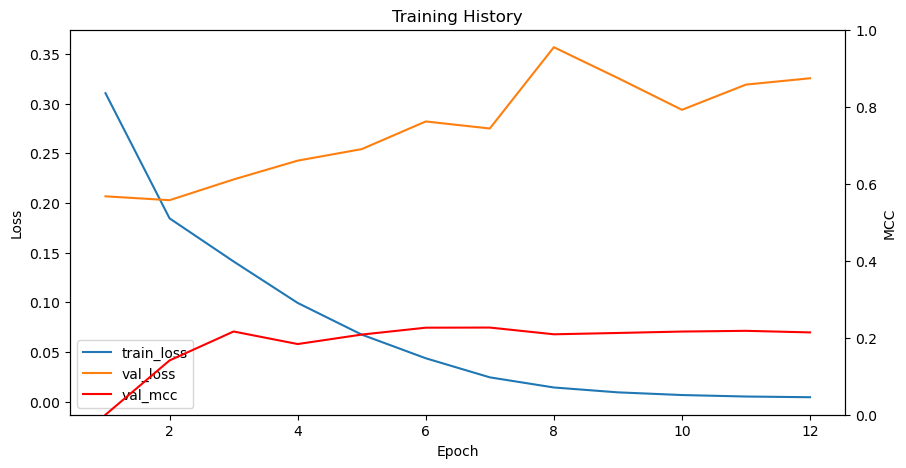

In [22]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Get mcc value 
metric = [x['eval_mcc'] for x in history if 'eval_mcc' in x]

epochs_loss = [x['epoch'] for x in history if 'loss' in x]
epochs_eval = [x['epoch'] for x in history if 'eval_loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
# For the loss we plot a horizontal line because we have just one loss value (after the first epoch)
# Exchange the two lines below if you trained multiple epochs
# line1 = ax1.plot([0]+epochs_loss, loss*2, label='train_loss')
line1 = ax1.plot(epochs_loss, loss, label='train_loss')

line2 = ax1.plot(epochs_eval, val_loss, label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line3 = ax2.plot(epochs_eval, metric, color='red', label='val_mcc')
ax2.set_ylabel('MCC')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()

# Save and Load the finetuned model

In [23]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    # torch.save(non_frozen_params, filepath)
    torch.save(
        OrderedDict({
            k: v
            for k, v in model.state_dict().items() # from https://github.com/pytorch/pytorch/issues/73825
            if k in non_frozen_params
        }), 
        filepath
    )

    
def load_model(checkpoint, filepath, num_labels=3, mixed = True, full = False, deepspeed=True):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load model
    if "esm" in checkpoint:
        model, tokenizer = load_esm_model_classification(checkpoint, num_labels, mixed, full, deepspeed)
    else:
        model, tokenizer = load_T5_model_classification(checkpoint, num_labels, mixed, full, deepspeed)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name] # .data # from https://github.com/pytorch/pytorch/issues/73825

    return tokenizer, model

In [24]:
save_model(model, "residues_fine_tuning/esm2_650.pth")

In [25]:
tokenizer, model_reload = load_model(checkpoint, "residues_fine_tuning/esm2_650.pth", num_labels=2, mixed = True, full = True, deepspeed=True)

Some weights of EsmForTokenClassificationCustom were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_3706192/3964414952.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_saf

Compare weights to check if the original and the reloaded models are identical

In [26]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have identical weights


# Make predictions on a test set

In [27]:
model = model_reload

In [28]:
# Drop unneeded columns (remember, mask was already included as -100 values to label)
my_test=pd.DataFrame(test_seqs[["sequence","label"]])

# Preprocess sequences
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
my_test.head(5)

,sequence,label
0,M F S R P G L P V E Y L Q V P S A S M G R D I ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,G S S H H H H H H S S G L V P R G S H M A S L ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,M K L S D L I S R W I D V E P S K N A Q I I L ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,M G S S H H H H H H S S G E T V R F Q G H M N ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,S N A M K I K K E S L E M R Q M R K K V V L I ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Then we create predictions on our test data using the model we trained before

In [29]:
# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']),checkpoint)
# Make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# For token classification we need a data collator here to pad correctly
if ("esm" in checkpoint) or ("ProstT5" in checkpoint):
    data_collator = DataCollatorForTokenClassificationESM(tokenizer) 
# For Ankh and ProtT5 pad only at the end
else:
    data_collator = DataCollatorForTokenClassification(tokenizer)  

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle = False, collate_fn = data_collator)

# Put the model in evaluation mode
model.eval()

# Make predictions on the test dataset
predictions = []
# We need to collect the batch["labels"] as well, this allows us to filter out all positions with a -100 afterwards
padded_labels = []

with torch.no_grad():
    for batch in test_dataloader:#tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Padded labels from the data collator
        padded_labels += batch['labels'].tolist()
        # Add batch results(logits) to predictions, we take the argmax here to get the predicted class
        predictions += model.float()(input_ids, attention_mask=attention_mask).logits.argmax(dim=-1).tolist()

Finally, we compute our desired performance metric for the test data

In [30]:
# to make it easier we flatten both the label and prediction lists
def flatten(l):
    return [item for sublist in l for item in sublist]

# flatten and convert to np array for easy slicing in the next step
predictions = np.array(flatten(predictions))
padded_labels = np.array(flatten(padded_labels))

# Filter out all invalid (label = -100) values
predictions = predictions[padded_labels!=-100]
padded_labels = padded_labels[padded_labels!=-100]

# Calculate classification Accuracy
print("Accuracy: ", accuracy_score(padded_labels, predictions))

Accuracy:  0.927910855063675


In [31]:
from sklearn.metrics import matthews_corrcoef, classification_report, confusion_matrix

y_true=padded_labels
y_pred=predictions

print("mcc", matthews_corrcoef(y_true, y_pred))
print("macro-f1", classification_report(y_true, y_pred, output_dict=True)["macro avg"]["f1-score"])
print(pd.DataFrame(confusion_matrix(y_true, y_pred)))

mcc 0.2207015118367202
macro-f1 0.603692921206056
       0    1
0  24173  591
1   1311  309
